# How to convert an image to ASCII

## Imports and example image

I will use matplotlib to read image and show progress, numpy to edit image like a 2D array and PIL to finish up and save the new image.

In [150]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

Look at this cat

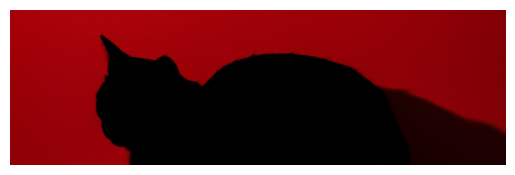

In [151]:
image = imread("cat.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()

## Grayscale
Colored images are not really 2D matricies because each pixel has several values for color: Red, Green and Blue.

We need to convert those 3 color values to a single "Brightness" value which will correspond to our ASCII characters. I also normalize it to (0,1) because it's a bit more intuitive later on


In [129]:
def grayscale(image, gamma=1.4,
              consts={"r": 0.2126, "g": 0.7152, "b": 0.0722}):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    grayscale_image = np.matrix(r*consts["r"]**gamma + g * \
        consts["g"]**gamma + b*consts["b"]**gamma, dtype=np.float32)
    return grayscale_image

Now our cat looks like this:

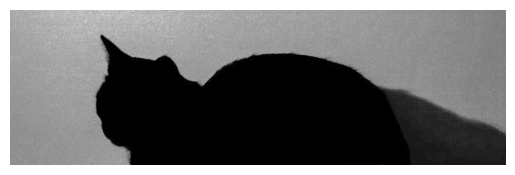

In [130]:
image = grayscale(image)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

## Downscale

Drawing a character per pixel is too much, considering each character takes several pixels to be readable, so we need to downscale our image and then represent each pixel with character.

This can be done by avaraging the value of a chunk of characters. The size of chunk is equal to some factor by which we downscale

In [131]:
def downscale(image, factor):
    new_size = image.shape[0]//factor, image.shape[1]//factor
    new_image = np.zeros(new_size, dtype=np.float32)
    for i in range(new_size[0]):
        for j in range(new_size[1]):
            new_image[i, j] = image[i * factor : (i + 1) * factor,
                                    j * factor : (j + 1) * factor].mean()
    return new_image

I'll downscal by the factor of 16 because it's very visible

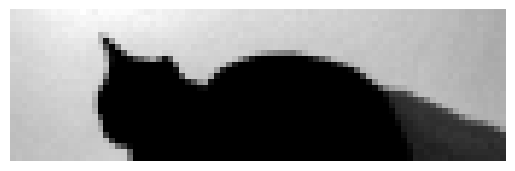

In [132]:
downscaled_image = downscale(image, 16)
plt.imshow(downscaled_image, cmap="gray")
plt.axis("off")
plt.show()

## Converting to ascii
Now we are almost ready to convert this image to ASCII charaters.

I'd like to use "■", "@", "#", "*", "+", "=", "-", ":", ".", " " characters, but

In [133]:
print("Min: ", downscaled_image.min())
print("Max: ", downscaled_image.max())


Min:  0.0
Max:  22.854465


See how the max is definately not an intager and also is to big for our list of ASCII character.

We need to reduce the colors. Which is very straightforward - we multiply each pixel by the amout of characters we got and divide it by max value, to get a number between 0 and our list length, also flooring the value by using "//" so we have nice intagers 

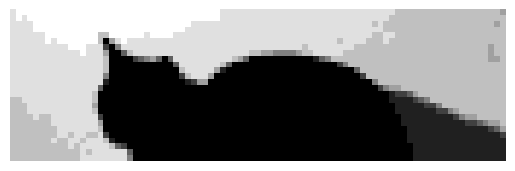

In [134]:
ascii_chars = ("■", "@", "#", "*", "+", "=", "-", ":", ".", " ")
downscaled_image = downscaled_image * (len(ascii_chars)-1) // downscaled_image.max()
plt.imshow(downscaled_image, cmap="gray")
plt.axis("off")
plt.show()

Look at these geese. Ordered, rounderd, moisturized.

In [135]:
print("Uniques: ", np.unique(downscaled_image))

Uniques:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]


Converting each integer to a character we will get a nice array to draw. 

In [136]:
def grayscale_to_ascii(image, ascii_chars):
    ascii_image = np.empty(image.shape, dtype=str)  # Create empty array for ASCII characters

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            ascii_image[i, j] =\
                ascii_chars[int(pixel_value)]  # Assign corresponding ASCII character
    return ascii_image

In [153]:
ascii_array = grayscale_to_ascii(downscaled_image, ascii_chars)
print(ascii_array[:5, :5])  # Print a small part of the ASCII array

[[':' '.' '.' '.' '.']
 [':' '.' ':' '.' '.']
 [':' ':' ':' ':' '.']
 [':' ':' ':' ':' '.']
 [':' ':' ':' ':' ':']]


And we just draw with pillow (PIL).

In [139]:
def draw_ascii_image(char_matrix, font_path="DejaVuSansMono.ttf", font_size=12, text_color=0, bg_color=255):
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        font = ImageFont.load_default()

    # Calculate character size
    bbox = font.getbbox('A')
    char_width = bbox[2] - bbox[0]
    char_height = bbox[3] - bbox[1]

    img_width = char_matrix.shape[1] * char_width
    img_height = char_matrix.shape[0] * char_height

    img = Image.new('L', (img_width, img_height), color=bg_color)
    draw = ImageDraw.Draw(img)

    for y, row in enumerate(char_matrix):
        for x, char in enumerate(row):
            draw.text((x * char_width, y * char_height), str(char), font=font, fill=text_color)

    return img

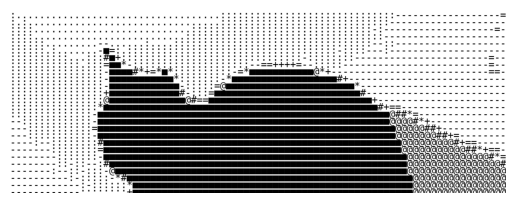

In [149]:
ascii_image = draw_ascii_image(ascii_array, font_size=32)
plt.imshow(ascii_image, cmap="gray")
plt.axis("off")
plt.show()

## Afterword
This is not the end, as I woul like to display the edges with "|", "_", "\\" and "/" characters to show Sobel edge detection method